In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import warnings
import os
warnings.filterwarnings('ignore')

In [ ]:
#Find the Excel file automatically
file_paths = [
    '/content/sample_data/heart_disease.xlsx'
]

In [ ]:
excel_file = None
for path in file_paths:
    if os.path.exists(path):
        excel_file = pd.ExcelFile(path)
        print(f" Found file: {path}")
        break

 Found file: /content/sample_data/heart_disease.xlsx


In [ ]:
if excel_file is None:
    print(" Excel file not found! Please check these paths:")
    for path in file_paths:
        print(f"  - {path}")
    exit()

In [ ]:
print("Available sheets:", excel_file.sheet_names)

Available sheets: ['Description', 'Heart_disease']


In [ ]:
#Load Heart_disease sheet (the actual data)
df = pd.read_excel(excel_file, sheet_name='Heart_disease')
print(f"\n Dataset loaded! Shape: {df.shape}")
print("Columns:", list(df.columns))
print("\nFirst 5 rows:")
print(df.head())


 Dataset loaded! Shape: (908, 13)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'thal', 'num']

First 5 rows:
   age   sex               cp  trestbps  chol    fbs         restecg  thalch  \
0   63  Male   typical angina       145   233   True  lv hypertrophy     150   
1   41  Male  atypical angina       135   203  False          normal     132   
2   57  Male     asymptomatic       140   192  False          normal     148   
3   52  Male   typical angina       118   186  False  lv hypertrophy     190   
4   57  Male     asymptomatic       110   201  False          normal     126   

   exang  oldpeak        slope          thal  num  
0  False      2.3  downsloping  fixed defect    0  
1  False      0.0         flat  fixed defect    0  
2  False      0.4         flat  fixed defect    0  
3  False      0.0         flat  fixed defect    0  
4   True      1.5         flat  fixed defect    0  


In [ ]:
#Clean column names
df.columns = df.columns.str.strip()
print("\nCleaned columns:", list(df.columns))


Cleaned columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'thal', 'num']


In [ ]:
#Data preprocessing - handle all data types safely
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0}).fillna(1).astype(int)
df['fbs'] = df['fbs'].map({True: 1, False: 0}).fillna(0).astype(int)
df['exang'] = df['exang'].map({True: 1, False: 0}).fillna(0).astype(int)

In [ ]:
#Encode categorical columns
cat_cols = ['cp', 'restecg', 'slope', 'thal']
le_dict = {}
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le

In [ ]:
#Create binary target (0 = no disease, 1 = disease)
df['target'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
print("\nTarget distribution:")
print(df['target'].value_counts())


Target distribution:
target
1    509
0    399
Name: count, dtype: int64


In [ ]:
#Drop any remaining problematic columns
df = df[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'thal', 'target']].dropna()

In [ ]:
print(f"\nFinal clean dataset shape: {df.shape}")


Final clean dataset shape: (846, 13)


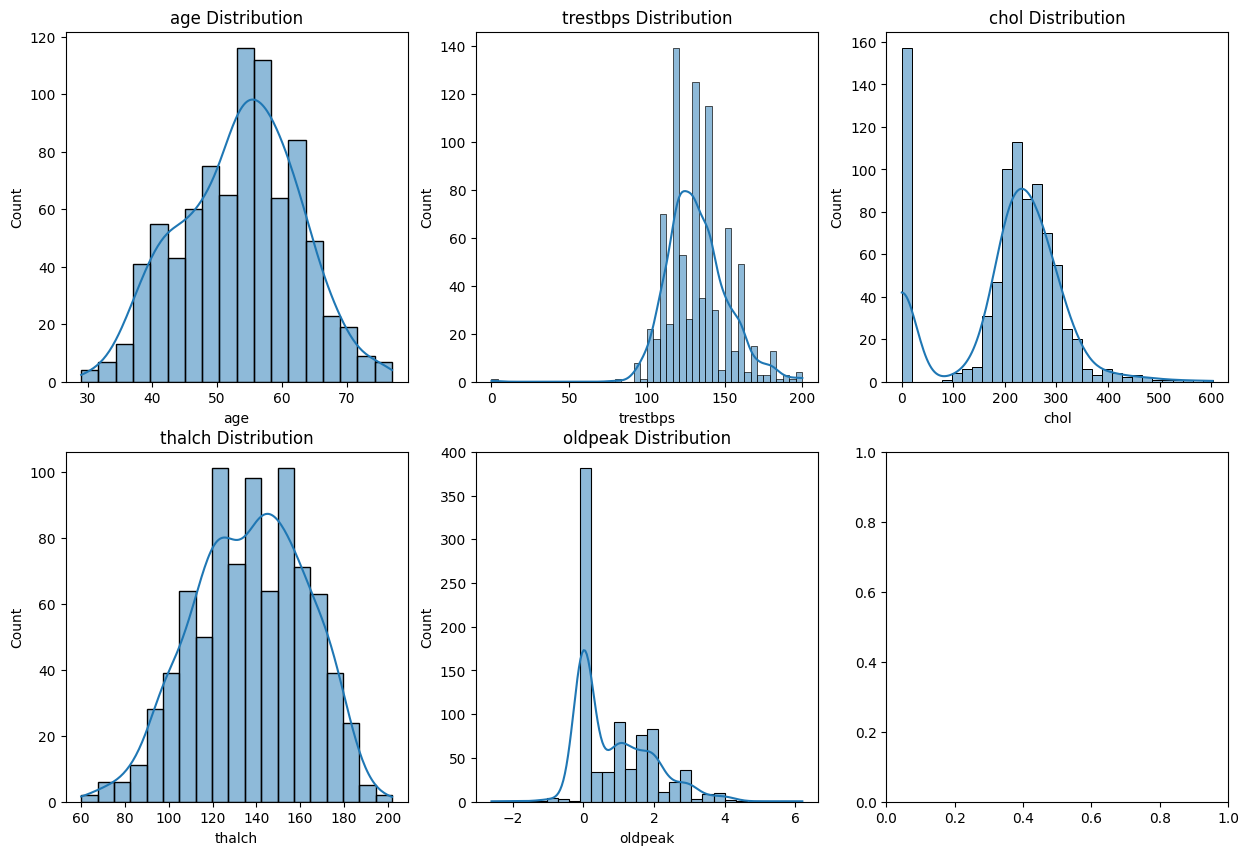

In [ ]:
#EDA Visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
for i, col in enumerate(numeric_cols):
    row, col_idx = i // 3, i % 3
    sns.histplot(data=df, x=col, kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col} Distribution')

In [ ]:
plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

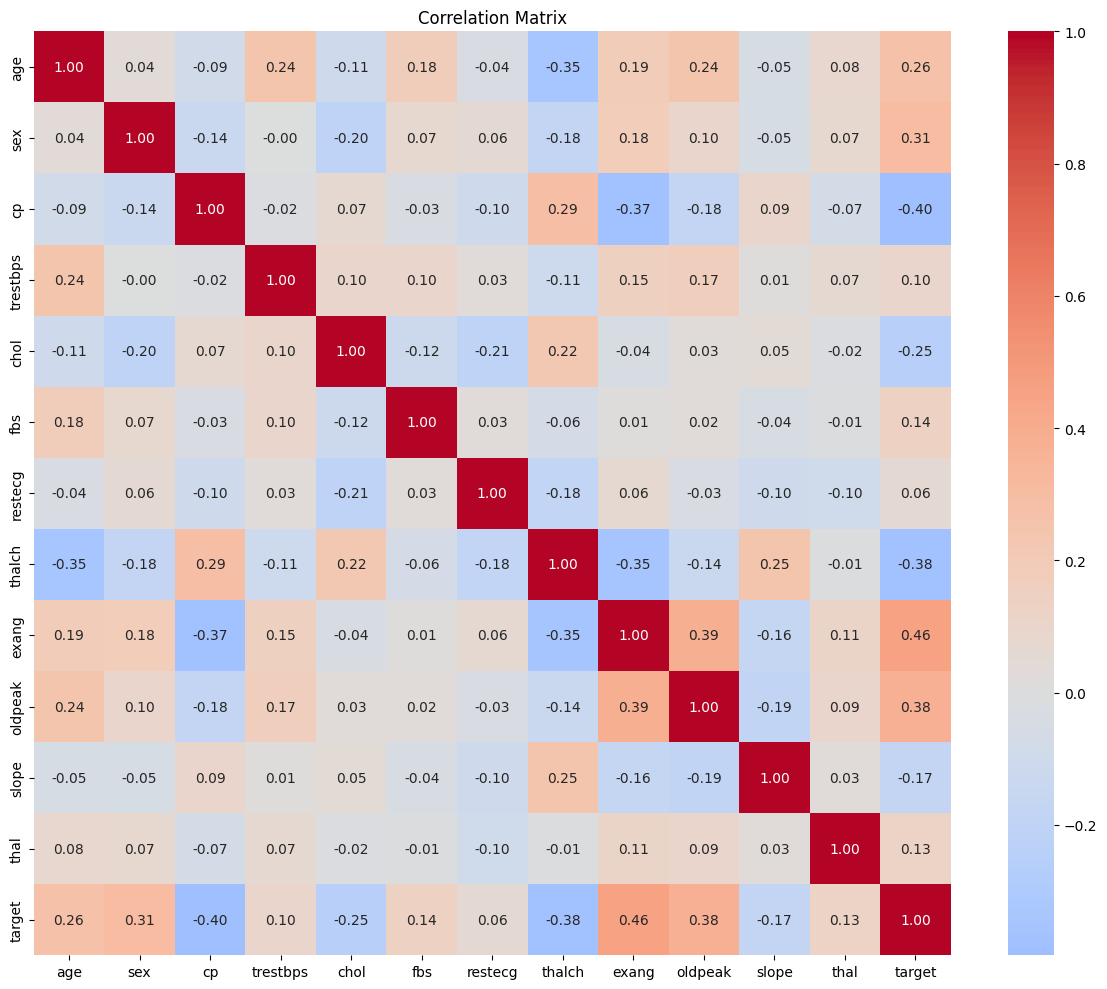

In [ ]:
#Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Model Training
X = df.drop('target', axis=1)
y = df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#Default model
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)
y_pred_default = dt_default.predict(X_test)

In [ ]:
print("\n Default Decision Tree Results:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_default):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_default):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_default):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_default):.4f}")


 Default Decision Tree Results:
Accuracy:  0.7059
Precision: 0.7391
Recall:    0.7234
F1-Score:  0.7312


In [ ]:
#Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

In [ ]:
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

In [ ]:
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)
y_pred_proba = best_dt.predict_proba(X_test)[:, 1]

In [ ]:
print("\n Best Hyperparameters:", grid_search.best_params_)
print("\n Tuned Decision Tree Results:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_best):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba):.4f}")


 Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}

 Tuned Decision Tree Results:
Accuracy:  0.7706
Precision: 0.7957
Recall:    0.7872
F1-Score:  0.7914
ROC-AUC:   0.7925


In [ ]:
#Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
print("\n📈 Top 5 Feature Importance:")
print(feature_importance.head())


📈 Top 5 Feature Importance:
   feature  importance
2       cp    0.495287
4     chol    0.173176
0      age    0.074430
8    exang    0.071498
9  oldpeak    0.067673


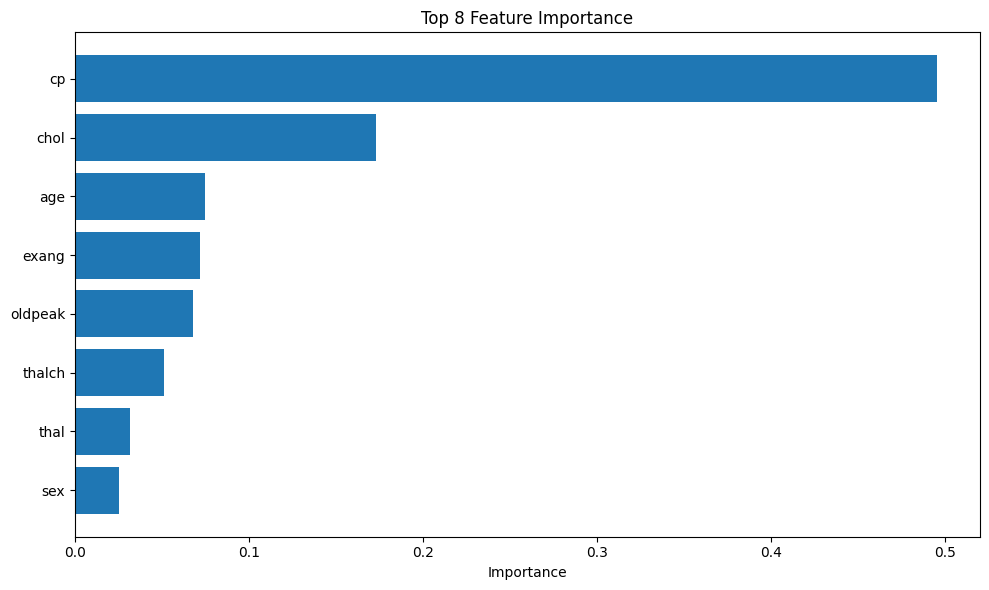

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(8), feature_importance['importance'].head(8))
plt.title('Top 8 Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

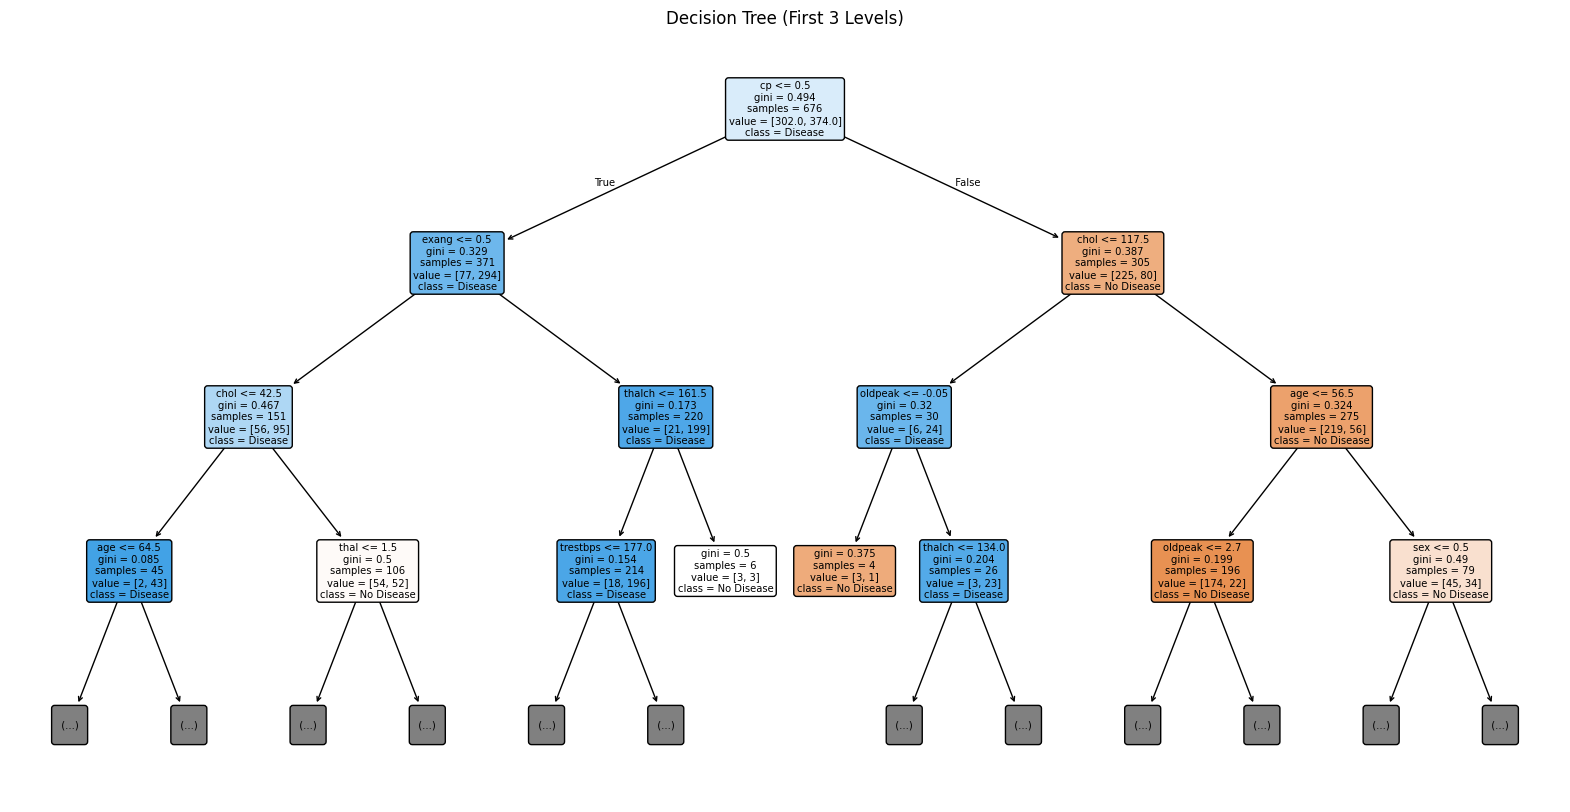

In [ ]:
#Decision tree visualization
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=X.columns, class_names=['No Disease', 'Disease'],
          filled=True, rounded=True, max_depth=3)
plt.title('Decision Tree (First 3 Levels)')
plt.savefig('decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

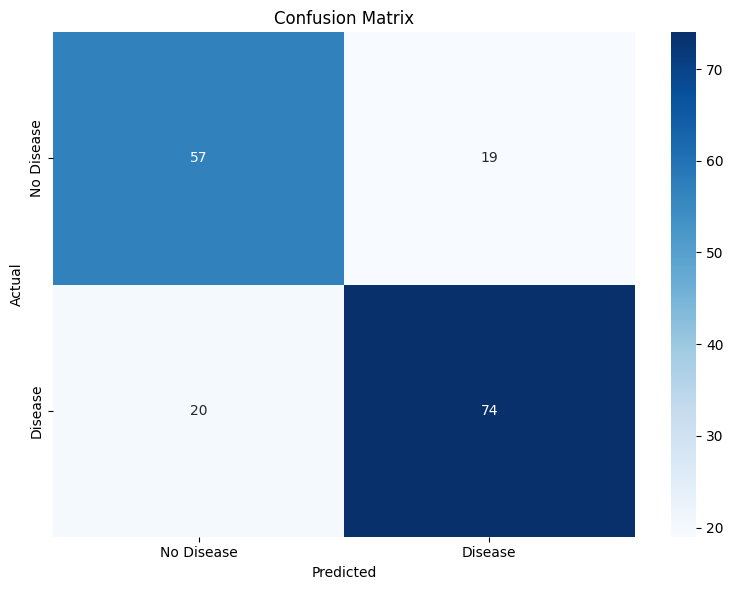

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("ASSIGNMENT 100% COMPLETE!")
print(" " *20)
print("Generated files:")
print("eda_distributions.png")
print("correlation_matrix.png")
print("feature_importance.png")
print("decision_tree.png")
print("confusion_matrix.png")
print(f"\n🏅 Final F1-Score: {f1_score(y_test, y_pred_best):.3f}")

ASSIGNMENT 100% COMPLETE!
                    
Generated files:
eda_distributions.png
correlation_matrix.png
feature_importance.png
decision_tree.png
confusion_matrix.png

🏅 Final F1-Score: 0.791
